In [1]:
import numpy as np
import pytesseract as tess
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# First Function to checkk the area , width and height of the roi
def check(area ,width ,height):
    ratio = float(width) / float(height)
    if (ratio <1 or ratio >6):
        return False
    else:
        return True

In [4]:
def isMaxWhite(plate_img):
    avg = np.mean(plate_img)
    
    if (avg>=115):
        return True
    else:
        return False
    

In [8]:
def ratio_of_width_and_height(rect):
    (x,y) , (width,height) ,rect_angle = rect
    
    if (width>height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle
        
    if angle>15:
        return False

    if (height ==0 or width ==0):
        return False
    
    else:
        return True
    

In [10]:
def clean_plate(img):  # Isolate only the license plate and display it.
    gray_img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    
    ret ,thresh = cv2.threshold(gray_img ,110,255 ,cv2.THRESH_BINARY)
    
    num_contours ,heirarchy = cv2.findContours(thresh.copy() ,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_NONE)
    
    if num_contours:
        contour_area = [cv2.contourArea(c) for c in num_contours]
        max_contour_index = np.argmax(contour_area)
        
        max_cnt = num_contours[max_contour_index]
        max_cnt_area = contour_area[max_contour_index]
        
        x,y,w,h = cv2.boundingRect(max_cnt)  # Draws a rectangle over the specified contour and returns the points.
        
        final_img = img[y:y+h ,x:x+w]
    
    else:
        print('No plate detected')  # NO plate

    cv2.imshow('Clean' ,img)
    
    if cv2.waitKey(0) & 0xff == ord('q'):
        pass

In [11]:
img = cv2.imread('license_plate.jpg')
cv2.imshow("input",img)
if cv2.waitKey(0) == ord('q'):
    pass

img2 = cv2.GaussianBlur(img , (3,3) , 0)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2 = cv2.Sobel(img2 ,cv2.CV_8U ,1,0 ,ksize=3)
ret,img2_thresh = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

element = cv2.getStructuringElement(shape = cv2.MORPH_RECT ,ksize=(12,6))  # I guess 17,3 are common license plate dimensions.
morph_img_threshold = img2_thresh.copy()

cv2.morphologyEx(img2_thresh ,op = cv2.MORPH_CLOSE ,kernel = element ,dst = morph_img_threshold)
num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)

cv2.drawContours(img2_thresh ,num_contours ,-1 ,(0,255,0) ,1)

for i,cnt in enumerate(num_contours):
    
    min_rect = cv2.minAreaRect(cnt)
    
    if ratio_of_width_and_height(min_rect):
        x,y,w,h = cv2.boundingRect(cnt)
        plate_img = img[y:y+h,x:x+w]
        print("Number  identified number plate...")
            
        cv2.imshow("num plate image",plate_img)
        if cv2.waitKey(0) & 0xff == ord('q'):
            pass
        
        if isMaxWhite(plate_img):
            clean_plate, rect = clean_plate(plate_img)
            if rect:
#                 x1,y1,w1,h1 = rect
#                 x,y,w,h = x+x1,y+y1,w1,h1
#                 # cv2.imwrite("clena.png",clean_plate)
                plate_im = Image.fromarray(clean_plate)
                text = tess.image_to_string(plate_im, lang='eng')
                print("Number  Detected Plate Text : ",text)

Number  identified number plate...


TypeError: cannot unpack non-iterable NoneType object

## TAKE 2 

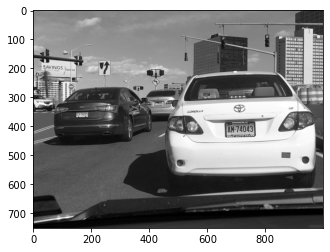

In [204]:
img = cv2.imread('license_plate.jpg')
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
gray_img = cv2.imread('license_plate.jpg' ,0)
img = cv2.resize(img, (780,580) )
plt.imshow(gray_img ,cmap='gray')

(-0.5, 999.5, 749.5, -0.5)

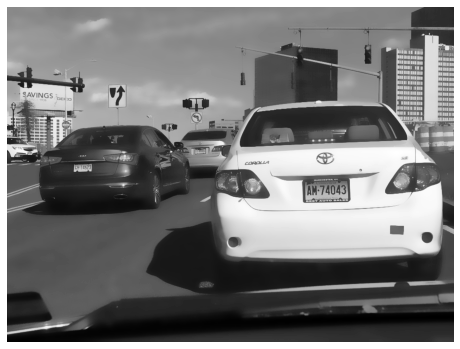

In [205]:
gray = cv2.bilateralFilter(gray_img, 21, 30, 30)

plt.figure(figsize=(8,8))
plt.imshow(gray ,cmap='gray')
plt.axis('off')

(-0.5, 999.5, 749.5, -0.5)

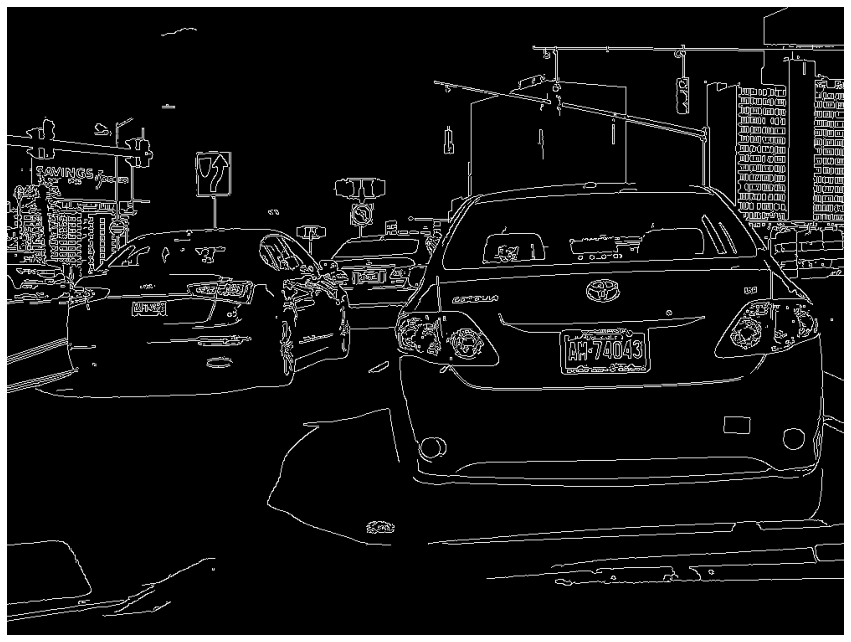

In [206]:
edge = cv2.Canny(gray.copy(),40,150)
plt.figure(figsize=(15,15))
plt.imshow(edge ,cmap='gray')
plt.axis('off')

In [207]:
import imutils

In [208]:
'''
In our image the counter could be anything that has a closed surface 
but of all the obtained results the license plate number will also be there since it is also a closed surface.
To filter the license plate image among the obtained results, we will loop though all the results and check which has a 
rectangle shape contour with four sides and closed figure. 
Since a license plate would definitely be a rectangle four sided figure.'''

contours  = cv2.findContours(edge.copy() ,cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)  # RETR GIVES FULL HEIRARCHY OF CONTOURS , INCLUDING EXTERNAL AND INTERNAL.
contours = imutils.grab_contours(contours)
contours = sorted(contours , key=cv2.contourArea ,reverse=True)[:18]
screenCnt = None


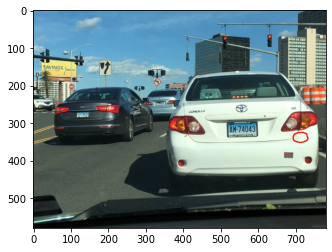

In [213]:
for i,cnt in enumerate(contours):
    # approximate the contour
    peri = cv2.arcLength(cnt ,True)  # Calculates the outer perimeter and as its closed , we specify True.
    approx = cv2.approxPolyDP(cnt ,0.1 * peri ,True)  # https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html
    
    '''
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    '''
    
    if len(approx) == 4:
        screenCnt = contours[i]
        break
        
plt.imshow(cv2.drawContours(img.copy() ,contours ,i , (255,0,0) ,2))

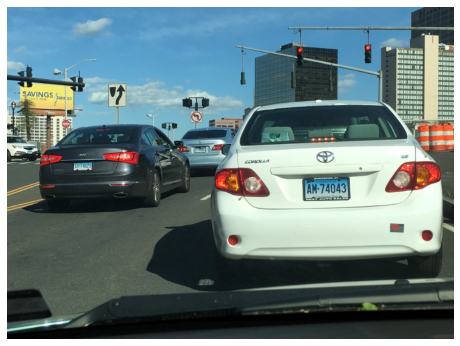

In [210]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(cv2.rectangle(img.copy() ,(x,y) ,(x+w ,y+h) ,(255,0,0) ,3))

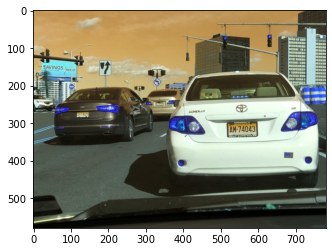

In [163]:
plt.imshow(img ,cmap='gray')